Reference: https://pennylane.ai/qml/demos/tutorial_learning_from_experiments  
*How useful is access to quantum memory for quantum machine learning?*

## The learning task  
The learning task we focus on involves deciding if a unitary is time-reversal symmetric (T-symmetric) or not. Mahtematically, time-reversal symmetry in quantum mechanics involves reversing the sens of $i$ so that $i \rightarrow -i$. Hence, a unitary $U$ is T-symmetric if  
$$U^*=U$$
Now for the learning task, let's say we have a bunch of quantum circuit $U_1, \dots, U_n$, some of which are T-symmetric and some not, but we are not told which ones are which  
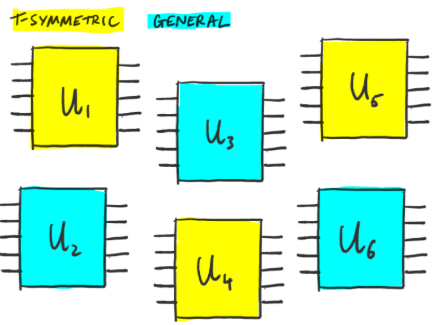  
The task is to design an algorithms to determine which of the $U$'s are T-symmetric and which are not, given query access to the unitaries. Note that we don't have any lables here, so this is an unsupervised learning taks. To make things concrete, let's consider unitaries acting on 8 qubits.

In [54]:
qubits = 8  # the number of qubits on which the unitaries act
n_shots = 100  # the number of times we can use each unitary

## Experiments with and without a quantum memory  
To tackle this task we consider experiments with and without quantum memory. We also assume that we have access to a single physical realization of each unitary; in other words, we do not have multiple copies of the devices that implement $U_i$  

An experiment w/o quantum memory can therefore only make use of a single query to $U_i$ in each circuit, since querying $U_i$ again would require storing the state of the first query in memory and re-using the unitary. In the paper these experiments are called **conventional experiments**.  

Experiment w/ quantum memory do not have the limitations of conventional experiments. This means that multiple queries can be made to $U_i$ in a single circuit, which can be realized in practice by using a quantum memory. These experiments are called **quantum-enhanced experiments**.  

Note that we are not comparing classical and quantum algorithms here, but rather two classes of quantum algorithms.  
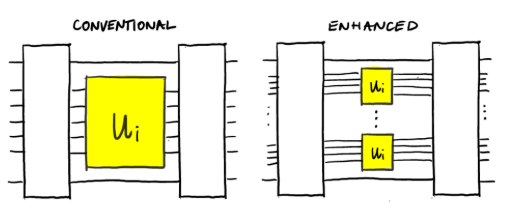  

## The conventional way  
First, we will try to solve the task w/ a conventional experiment. Our strategy will be as follows.  
* For each $U_i$, we prepare ```n_shots``` copies of the state $U_i|0\rangle$ nad measure each state to generate classical measurement data. 
* Use an unsupervised classical machine learning algorithms (kernel PCA), to try and separate the data into two clusters corresponding to T-symemetric unitaries vs. the rest. 

If we succeed in clustering the data then we have successfully managed to discriminate the two classes!  
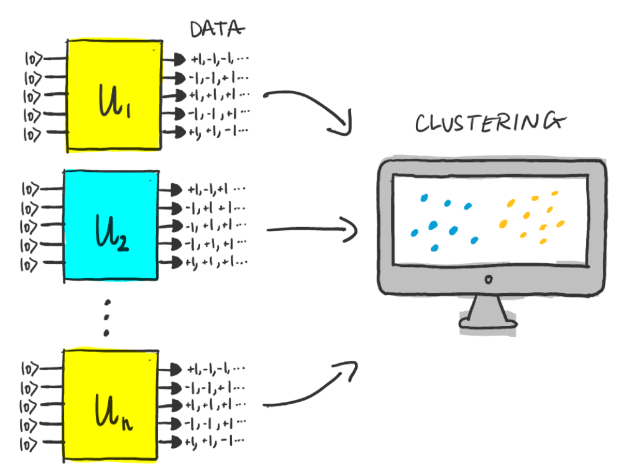  
To generate the measurement data, we will measure the states $U_i|0\rangle$ in the $y$ basis. The local expectation values take the form  
$$E_i = \langle 0 |U^{\dagger}\sigma_y^{(i)}U|0\rangle$$
Using the fact that $\sigma_y^* = - \sigma_y$ and the property $U^*=U$ for T-symmetric unitaries, one finds  
$$E_i^* = \langle 0 |(U^{\dagger})^*(\sigma_y^{(i)})^*(U)^*|0\rangle = -\langle 0|U^{\dagger}\sigma_y^{(i)}U|0\rangle = -E_i$$
Since $E_i$ is a real number, the only solution to this is $E_i=0$, which implies that all local expectations values are 0 for this class.  

For general unitaries it is not the case that $E_i=0$, and so it seems as though this will allow us to discriminate the two classes of circuits easily. However, for general random unitaries the local expectation values approach zero exponentially with the number of qubits. It is proven that using conventional experiments, any successful algorithms *must* use the unitaries an exponential number of times  

Let's wee how this looks in practice. First we define a funciton to generate the random unitaries. For the time-symmetric case we will only allow for Y rotations, since these unitaries contain only real numbers, and therefore result in T-symmetric unitaries. For the other unitaries, we will allow rotation about X, Y, and Z

정리하면, T-symmetric 유니터리는 Y-기댓값이 항상 0 이어야 한다. 따라서 어떠한 유니터리를 거친 양자 상태에 대해 y 측정을 했을 때 기댓값이 0인지 아닌지에 따라 구별이 가능함. T-symmetric은 rotation-y로만 섞어서 만들면 자동으로 구성됨. 행렬을 생각해볼때 $i$성분이 사라져서 $U=U^*$가 되기 때문

In [81]:
import pennylane as qml
from pennylane.templates.layers import RandomLayers
import numpy as np

np.random.seed(234087)

layers, gates = 10, 10  # the number of layers and gates used in RandomLayers


def generate_circuit(shots):
    """
    generate a random circuit that returns a number of measuement samples
    given by shots
    """
    dev = qml.device("lightning.qubit", wires=qubits)

    @qml.set_shots(shots)
    @qml.qnode(dev)
    def circuit(ts=False):

        if ts == True:
            ops = [qml.RY]  # time-symmetric unitaries
        else:
            ops = [qml.RX, qml.RY, qml.RZ]  # general unitaries

        weights = np.random.rand(layers, gates) * np.pi
        RandomLayers(weights, wires=range(qubits), rotations=ops, seed=np.random.randint(0, 10000))

        return [qml.sample(op=qml.PauliY(q)) for q in range(qubits)]

    return circuit

In [82]:
circuit = generate_circuit(n_shots)
print(np.array(circuit(ts=True))[:, 0:3])
print()
print(np.array(circuit(ts=False))[:, 0:3])

[[ 1. -1.  1.]
 [-1.  1.  1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]
 [ 1.  1.  1.]
 [ 1.  1. -1.]
 [-1.  1.  1.]
 [-1.  1.  1.]]

[[ 1.  1. -1.]
 [-1. -1.  1.]
 [-1. -1. -1.]
 [ 1. -1.  1.]
 [-1. -1.  1.]
 [-1.  1. -1.]
 [ 1.  1. -1.]
 [-1.  1.  1.]]


In [83]:
circuits = 30
raw_data = []
for ts in [True, False]:
    for _ in range(circuits):
        circuit = generate_circuit(n_shots)
        raw_data.append(circuit(ts=ts))

In [84]:
def process_data(raw_data):
    raw_data =np.array(raw_data)

    nc = len(raw_data)
    nq = len(raw_data[0])
    new_data = np.zeros([nc, 2 * nq])

    for k, outcomes in enumerate(raw_data):
        means = [np.mean(outcomes[q, :]) for q in range(nq)]
        variance = [np.var(outcomes[q, :]) for q in range(nq)]
        new_data[k] = np.array(means + variance) # 리스트 두 개가이므로 broadcasting이 아님. 병렬로 더해짐

    return new_data

data = process_data(raw_data)

Now we use scikit-learn's kernel PCA to try cluster the data. 얘는 고차원 kernel에서 PCA 함

In [85]:
from sklearn.decomposition import KernelPCA
from sklearn import preprocessing

kernel_pca = KernelPCA(n_components = None,
                       kernel = 'rbf',
                       gamma = None,
                       fit_inverse_transform = True,
                       alpha = 0.1)

scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
fit = kernel_pca.fit(data).transform(data)

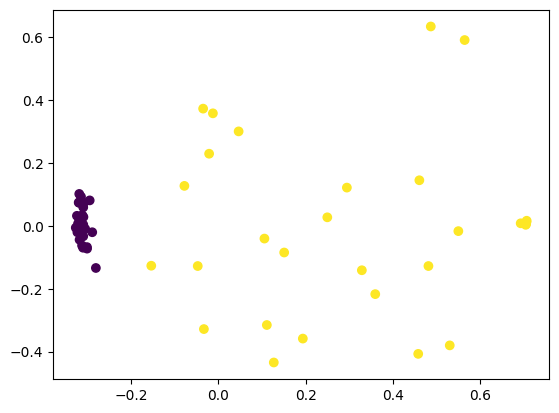

In [86]:
import matplotlib.pyplot as plt

c = np.array([0 for _ in range(circuits)] + [1 for _ in range(circuits)]) # 첫 30개는 time-symmetric, 다음 30개는 general
plt.scatter(fit[:,0], fit[:, 1], c= c,)
plt.show()

Looks like the algorithms failed to cluster the data. We can try to get a seperation by incresing the # of shots. Let's increase the number of shots by 10000 and see what happens

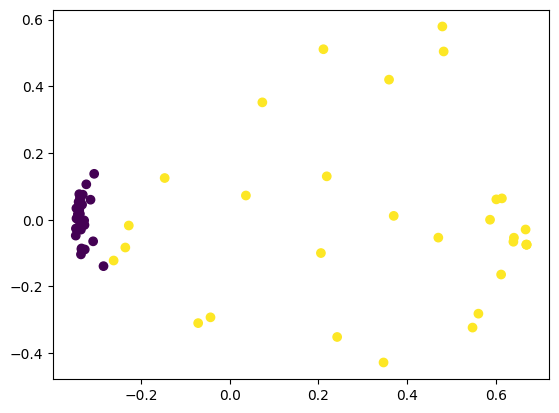

In [87]:
n_shots = 10000  # 100 x more shots

raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        circuit = generate_circuit(n_shots)
        raw_data.append(circuit(ts=ts))

data = process_data(raw_data)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

fit = kernel_pca.fit(data).transform(data)

plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

Now we have a seperation, however we required a lot of shots from the quantum circuit. As we increase the number of qubits, the number of shots we need will scale exponentially, and so conventional strategies cannot learn to separate the data efficiently.

## The quantum-enhanced way  
Now let's see what difference having a quantum memory can make. Instead of using a single unitary to generate measurement data, we will make use of twice the number of qubits, and apply the unitary twice:  
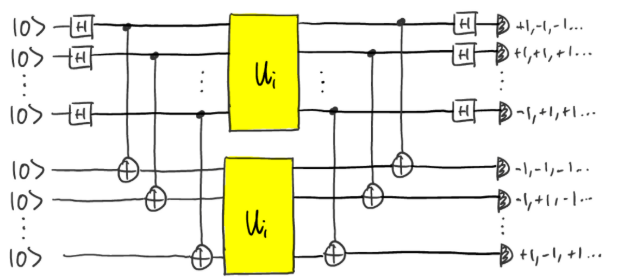  
In practice, this could be done by storing the output state from the first unitary in quantum memory and preparing the same state by using the unitary again. Let's define a function ```enhanced_circuit()``` to implement that. Note that since we now have twice as many qubits, we use half the number of shots as before **so that the total number of uses of the unitary is unchanged**

In [ ]:
n_shots = 50
qubits = 8

dev = qml.device("lightning.qubit", wires=qubits * 2)


def CNOT_sequence(control_wires, target_wires):
    """Apply CNOTs in sequence using the provided control and target wires"""
    for c_wire, t_wire in zip(control_wires, target_wires):
        qml.CNOT([c_wire, t_wire])


@qml.set_shots(n_shots)
@qml.qnode(dev)
def enhanced_circuit(ts=False):
    "implement the enhanced circuit, using a random unitary"

    if ts == True:
        ops = [qml.RY]
    else:
        ops = [qml.RX, qml.RY, qml.RZ]

    weights = np.random.rand(layers, n_shots) * np.pi
    seed = np.random.randint(0, 10000)

    for q in range(qubits):
        qml.Hadamard(wires=q)

    CNOT_sequence(control_wires=range(qubits), target_wires=range(qubits, 2 * qubits))
    RandomLayers(weights, wires=range(0, qubits), rotations=ops, seed=seed)
    RandomLayers(weights, wires=range(qubits, 2 * qubits), rotations=ops, seed=seed)
    CNOT_sequence(control_wires=range(qubits), target_wires=range(qubits, 2 * qubits))

    for q in range(qubits):
        qml.Hadamard(wires=q)

    return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)] # quantum-enhanced way에서는 Y측정이 아닌 Z 측정
    # 이 회로의 의의는 앞의 conventional way랑 좀 다름.
    # 얘는 똑같은 unitary를 두 번 사용한 후의 결과과 처음과 얼마나 일치하는지 확인하는 테스트임
    # 먼저 초기 사태를 H와 CNOT으로 psi로 만들 고, T-sym U를 거침. 
    # 근데 T-symm는 psi가 유지되고, 이후 CNOT과 H를 다시 거쳐 초기 상태로 돌아옴.
    # 만약 일반 U라면 psi가 유지되지 않아서 초기 상태로 돌아오지 못함.
    # 따라서 Z측정으로 초기 상태와의 일치도를 확인하는 것임.

In [89]:
raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        raw_data.append(enhanced_circuit(ts))

data = process_data(raw_data)

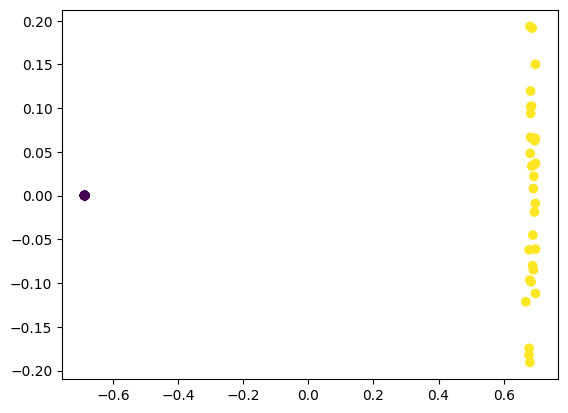

In [91]:
kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)

scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)

fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

perfectly separated! In face, all the T-symm uni have been mapped to the same point. This is because the circuit is actually equivalent to performing $U^T U\otimes I|0\rangle$, which for T-symmetric unitaries is just the identity operation.  

To see this, note that the H and CNOT gate befor $U_i\otimes U_i$ map the $|0\rangle$ state to the maximally entangled state $|\Phi^+\rangle = \frac{1}{\sqrt{2}}(|00\dots0\rangle + |11\dots1\rangle)$, and the gates after $U_i \otimes U_i$ are just the inverse transformation. The prob that all meas outcoms give the result +1 is therefore  
$$p(11\dots 1)=\langle \Phi^+|U_i \otimes U_i|\Phi^+\rangle$$
A well known fact about the maximally entanged state is that $U\otimes I|\Phi^+\rangle = I \otimes U^T|\Phi^+ \rangle$. The prob is therefore  
$$p(11\dots 1)=\langle \Phi^+|U_i^T U_i \otimes I|\Phi^+\rangle$$
For T-symm uni $U^T =U^{\dagger}$, so this prob is equal to one: the $11\dots 1$ is always btained.  

Look at the raw meas data for T-symm uni

In [92]:
np.array(raw_data[0])[:, 0:5]  # outcomes of first 5 shots of the first T-symmetric circuit

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

To make things a bit more interesting, let's add some noise to the circuit. We define a function ```noise_layer(epsilon)``` that adds some random single qubit rotations, where the maximum rotation angle is ```epsilon```.

In [109]:
def noise_layer(epsilon):
    for q in range(qubits * 2):
        angle = (2*np.random.rand(3) -1) * epsilon
        qml.Rot(angle[0], angle[1], angle[2], wires=q)

In [110]:
@qml.set_shots(n_shots)
@qml.qnode(dev)
def enhanced_circuit(ts=False):
    "implement the enhanced circuit, using a random unitary with a noise layer"

    if ts == True:
        ops = [qml.RY]
    else:
        ops = [qml.RX, qml.RY, qml.RZ]

    weights = np.random.rand(layers, n_shots) * np.pi
    seed = np.random.randint(0, 10000)

    for q in range(qubits):
        qml.Hadamard(wires=q)

    CNOT_sequence(control_wires=range(qubits), target_wires=range(qubits, 2 * qubits))
    RandomLayers(weights, wires=range(0, qubits), rotations=ops, seed=seed)
    RandomLayers(weights, wires=range(qubits, 2 * qubits), rotations=ops, seed=seed)
    noise_layer(np.pi / 4)  # added noise layer
    CNOT_sequence(control_wires=range(qubits, 2 * qubits), target_wires=range(qubits))

    for q in range(qubits):
        qml.Hadamard(wires=qubits + q)

    return [qml.sample(op=qml.PauliZ(q)) for q in range(2 * qubits)]

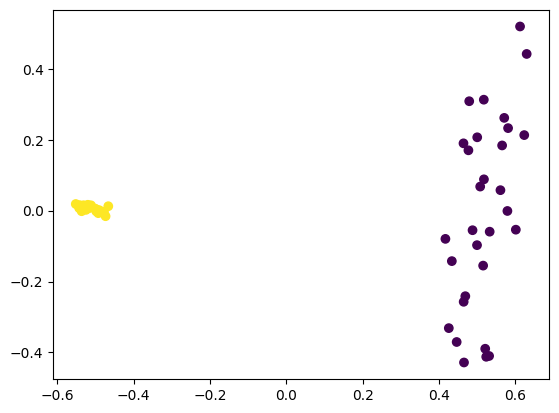

In [111]:
raw_data = []

for ts in [True, False]:
    for __ in range(circuits):
        raw_data.append(enhanced_circuit(ts))

data = process_data(raw_data)

kernel_pca = KernelPCA(
    n_components=None, kernel="rbf", gamma=None, fit_inverse_transform=True, alpha=0.1
)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
fit = kernel_pca.fit(data).transform(data)

c = np.array([0 for __ in range(circuits)] + [1 for __ in range(circuits)])
plt.scatter(fit[:, 0], fit[:, 1], c=c)
plt.show()

Nice! Even in the presence of noise we still have a clean separation of the two classes. This shows that using entanglement can make a big difference to learning.